In [1]:
import pandas as pd
import numpy as np
import talib
import pandas_profiling as pdp
import sweetviz as sv

import os
import sys
from pygam import s, LinearGAM
import category_encoders as ce
from typing import List, Dict

import matplotlib.pyplot as plt
import seaborn as sns

import ptitprince
from matplotlib_venn import venn2
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

from common_module.utils.plot import (
    plot_venn,
    plot_histogram,
    plot_raincloud,
    plot_heatmap,
    plot_histgram_for_valid,
    plot_lineargam,
    plot_feature_importance_for_valid
)
from common_module.utils.summarize import (
    get_pandas_profiling,
    get_sweetviz_report
)
from common_module.utils.preprocessor import (
    OrdinalEncodingBlock,
    CountEncodingBlock,
    GroupingBlock
)
from common_module.utils.format_df import format_df
from common_module.utils.utils import (
    reduce_mem_usage,
    save_pickle,
    load_pickle
)
from common_module.utils.metrics import (
    calc_MAE,
    calc_MSE,
    calc_RMSE,
    calc_RMSLE
)

from probspace_kiva.modules.config_manager import ConfigManager
# from probspace_kiva.modules.preprocessor import ConcatTrainTestDf
# from probspace_kiva.modules.features import FeatureEngineering
from probspace_kiva.modules.validator import (
    make_KFold,
    add_true_for_valid
)
from probspace_kiva.modules.train_module import (
    TrainLGBModule,
    TrainCABModule,
    TrainXGBModule
)
from probspace_kiva.modules.predict import PredictModule
# from probspace_kiva.modules.adversarial_validator import AdversarialValidator


sys.path.append("../")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/saitouteruaki/.local/share/virtualenvs/data_science-EJAMj-NW/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## config

In [2]:
input_path = "../input/"
output_path = "../output/"

## データ読み込み

In [3]:
df_train_origin = pd.read_csv(os.path.join(input_path, "train.csv"), encoding="utf-8-sig")
df_test_origin = pd.read_csv(os.path.join(input_path, "test.csv"), encoding="utf-8-sig")
df_sample = pd.read_csv(os.path.join(input_path, "sample_submission.csv"), encoding="utf-8-sig")

print(f"df_train_origin: {df_train_origin.shape}")
print(f"df_test_origin: {df_test_origin.shape}")
print(f"df_sample: {df_sample.shape}")

df_train_origin: (91333, 18)
df_test_origin: (91822, 17)
df_sample: (91822, 2)


## EDA

### profile

In [10]:
# 実行失敗
# get_pandas_profiling(df=df_train_origin, output_path=output_path, output_name="pandas_train_profile")
# get_pandas_profiling(df=df_test_origin, output_path=output_path, output_name="pandas_test_profile")

In [11]:
# 実行成功
# get_sweetviz_report(train=df_train_origin, test=df_test_origin, output_path=output_path, output_name="sweetviz_report")

                                             |                                                                …

Report ../output/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## BaseLine

### 方針
- 特徴量
    - ORIGINAL_LANGUAGE: category
    - ACTIVITY_NAME: category
    - SECTOR_NAME: category
    - COUNTRY_NAME: category
    - CURRENCY_POLICY: category
    - CURRENCY: category
    - REPAYMENT_INTERVAL: category
- 目的変数
    - LOAN_AMOUNT_log1p: LOAN_AMOUNTを対数変換させたもの。対数取るとおおよそ正規分布になる
- 損失関数
    - RMSE: 評価関数はMAEだけど正解/予測の比率を1に近づければMAEも低くなるのではという発想
- モデル
    - LightGBM
- CV
    - KFold
- 結果
    - 上記だけでは分割できないため、同じ結果になっているLOAN＿IDが複数あった

In [13]:
# config読み込み
config = ConfigManager(config_path="../config/baseline_setting.yaml")

# データ型を修正しメモリを削減する
df_train = reduce_mem_usage(df_train_origin)
df_test = reduce_mem_usage(df_test_origin)
# dtypeのフォーマット修正
df_train = format_df(df_train, dtype_definition=config.feature_columns)
df_test = format_df(df_test, dtype_definition=config.feature_columns)
# 目的変数作成
df_train["LOAN_AMOUNT_log1p"] = np.log1p(df_train["LOAN_AMOUNT"])

Memory usage of dataframe is 12.54 MB
Memory usage after optimization is: 12.00 MB
Decreased by 4.4%
Memory usage of dataframe is 11.91 MB
Memory usage after optimization is: 11.77 MB
Decreased by 1.2%


In [14]:
model_set = {}
importance_set = {}
evals_set = {}
df_val_set = {}
df_test_set = {}
df_val_list = []
df_test_list = []

print(f"train {config.target} ...")
# インスタンス生成
ins_lgb_train = TrainLGBModule(config=config, target=config.target, exec_advasarial_validation=False)
ins_lgb_val_pred = PredictModule(config=config, target=config.target, model_type="lightgbm", is_test=False, clip=False)
ins_lgb_test_pred = PredictModule(config=config, target=config.target, model_type="lightgbm", is_test=True, clip=False)

# kfolds
folds_idx = make_KFold(
    train_x=df_train,
    train_y=df_train[config.target],
    n_splits=config.n_splits,
    random_state=config.random_state
)
# 学習
for cv_num, (tr_idx, va_idx) in enumerate(folds_idx):
    df_train_t, df_train_v = df_train.loc[tr_idx, :], df_train.loc[va_idx, :]
    model_lgb, df_imp_lgb, evals_result_lgb = ins_lgb_train.train_model(train=df_train_t, valid=df_train_v, have_weight=False)
    # dataset への保存
    model_set[f"{config.target}_{cv_num}"] = model_lgb
    importance_set[f"{config.target}_{cv_num}"] = df_imp_lgb
    evals_set[f"{config.target}_{cv_num}"] = evals_result_lgb
    # validationデータを予測
    df_val_pred_lgb = ins_lgb_val_pred.predict(model=model_lgb, test_df=df_train_v, cv_num=cv_num)
    df_val = add_true_for_valid(origin_df=df_train_v, pred_df=df_val_pred_lgb, target=config.target, cv_num=cv_num, config=config)
    use_cols = [f"true_{config.target}", f"pred_{config.target}"]
    df_val[f"true_{config.target}_expm1y"] = np.expm1(df_val[f"true_{config.target}"])
    df_val[f"pred_{config.target}_expm1y"] = np.expm1(df_val[f"pred_{config.target}"])
    mae_score = calc_MAE(
        y_true=df_val[f"true_{config.target}_expm1y"],
        y_pred=df_val[f"pred_{config.target}_expm1y"]
    )
    print(f"■ target_col={config.target} | cv_num={cv_num} | mae_score={mae_score:.4f}")
    df_val_set[f"{config.target}_{cv_num}"] = df_val
    df_val_list.append(df_val)
    # testデータを予測
    df_test_pred_lgb = ins_lgb_test_pred.predict(model=model_lgb, test_df=df_test, cv_num=cv_num)
    df_test_pred_lgb[f"pred_{config.target}_expm1y"] = np.expm1(df_test_pred_lgb[f"pred_{config.target}"])
    df_test_set[f"{config.target}_{cv_num}"] = df_test_pred_lgb
    df_test_list.append(df_test_pred_lgb)
    print("=" * 70)

# validationデータ全体のcvスコア
print("~" * 70)
df_valid_results = pd.concat(df_val_list, ignore_index=True, sort=False)
mae_score_all = calc_MAE(
    y_true=df_valid_results[f"true_{config.target}_expm1y"],
    y_pred=df_valid_results[f"pred_{config.target}_expm1y"]
)
print(f"■ target_col={config.target} | mae_score={mae_score_all:.4f}")

train LOAN_AMOUNT_log1p ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	train's rmse: 0.546695	valid's rmse: 0.563699
pred LOAN_AMOUNT_log1p ...
■ target_col=LOAN_AMOUNT_log1p | cv_num=0 | mae_score=309.7270
pred LOAN_AMOUNT_log1p ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	train's rmse: 0.546994	valid's rmse: 0.563006
pred LOAN_AMOUNT_log1p ...
■ target_col=LOAN_AMOUNT_log1p | cv_num=1 | mae_score=312.1025
pred LOAN_AMOUNT_log1p ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	train's rmse: 0.547911	valid's rmse: 0.560284
pred LOAN_AMOUNT_log1p ...
■ target_col=LOAN_AMOUNT_log1p | cv_num=2 | mae_score=309.5413
pred LOAN_AMOUNT_log1p ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[187]	train's rmse: 0.546741	valid's rmse: 0.561845
pred LOAN_AMOUNT_log1p ..

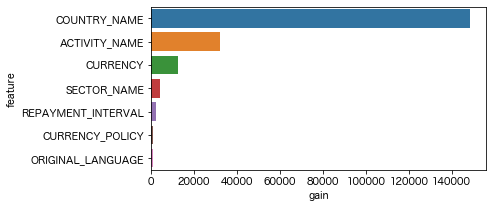

In [15]:
df_imp_ = df_imp_lgb.sort_values("gain", ascending=False)
plt.figure(figsize=(6, 3))
sns.barplot(x=df_imp_["gain"], y=df_imp_["feature"]);

In [16]:
# cv回数分のtest結果の中央値を最終結果とする
df_test_concat = pd.concat(df_test_list, ignore_index=True, sort=False)
df_test_results = df_test_concat.groupby("LOAN_ID", as_index=False)[f"pred_{config.target}_expm1y"].mean()
df_test_results.columns = ["LOAN_ID", "LOAN_AMOUNT"]
df_test_results = df_test_results.sort_values("LOAN_ID")
df_test_results.to_csv(os.path.join(config.output_path, "submission_1.csv"), encoding="utf-8-sig", index=False)

In [17]:
df_test_results.head()

,LOAN_ID,LOAN_AMOUNT
0,1904656,2986.500277
1,1904657,2368.486435
2,1904659,349.331903
3,1904660,349.331903
4,1904661,349.331903


In [18]:
df_test[df_test["LOAN_ID"].isin([1904659, 1904660, 1904661])]

,LOAN_ID,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,IMAGE_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
6312,1904660,English,"Meet Catherine 50, (pictured with her farming ...","Meet Catherine 50, (pictured with her farming ...",3348720,Farming,Agriculture,\tto buy farm inputs such as high-quality fert...,KE,Kenya,Kapcherop,shared,0.0,KES,NaN,monthly,field_partner
35906,1904659,English,Meet Jones (pictured in his tea plantation).\n...,Meet Jones (pictured in his tea plantation).\n...,3348729,Farming,Agriculture,a single dad of 2 to purchase farming inputs s...,KE,Kenya,Nyamira,shared,0.0,KES,NaN,monthly,field_partner
76426,1904661,English,Mary’s (65 years old mom of 4) curiosity and n...,Mary’s (65 years old mom of 4) curiosity and n...,3348715,Farming,Agriculture,\tto purchase farming inputs such as high-nutr...,KE,Kenya,litein,shared,0.0,KES,"#Elderly, user_favorite, user_favorite",monthly,field_partner


<AxesSubplot:ylabel='Frequency'>

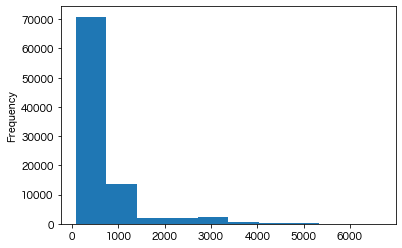

In [11]:
df_test_results["LOAN_AMOUNT"].plot(kind="hist")